In [11]:
# LIBRARIES

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.autograd import grad
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # hopefully runs on GPU
folder_exp = 'models/model/' # path to trained model

In [12]:
# DATASET 

N_train = 20000
N_val = 6384
N_test = 6384
d = 256 # number of particles in each simulation
d_cond = 2 # number of information for describing a simulation

Q000, P000 = np.load('data/Q00.npy'), np.load('data/P00.npy')
Q010, P010 = np.load('data/Q05.npy'), np.load('data/P05.npy')
Q020, P020 = np.load('data/Q10.npy'), np.load('data/P10.npy')
Q030, P030 = np.load('data/Q15.npy'), np.load('data/P15.npy')
Q040, P040 = np.load('data/Q20.npy'), np.load('data/P20.npy')
Q050, P050 = np.load('data/Q25.npy'), np.load('data/P25.npy')
Cond = np.load('data/Cond.npy')

Q000_test_numpy, P000_test_numpy = Q000[N_train+N_val:N_train+N_val+N_test], P000[N_train+N_val:N_train+N_val+N_test]
Q010_test_numpy, P010_test_numpy = Q010[N_train+N_val:N_train+N_val+N_test], P010[N_train+N_val:N_train+N_val+N_test]
Q020_test_numpy, P020_test_numpy = Q020[N_train+N_val:N_train+N_val+N_test], P020[N_train+N_val:N_train+N_val+N_test]
Q030_test_numpy, P030_test_numpy = Q030[N_train+N_val:N_train+N_val+N_test], P030[N_train+N_val:N_train+N_val+N_test]
Q040_test_numpy, P040_test_numpy = Q040[N_train+N_val:N_train+N_val+N_test], P040[N_train+N_val:N_train+N_val+N_test]
Q050_test_numpy, P050_test_numpy = Q050[N_train+N_val:N_train+N_val+N_test], P050[N_train+N_val:N_train+N_val+N_test]
Cond_test_numpy = Cond[N_train+N_val:N_train+N_val+N_test]

Q000_test, P000_test = torch.tensor(Q000_test_numpy,dtype=float), torch.tensor(P000_test_numpy,dtype=float)
Q010_test, P010_test = torch.tensor(Q010_test_numpy,dtype=float), torch.tensor(P010_test_numpy,dtype=float)
Q020_test, P020_test = torch.tensor(Q020_test_numpy,dtype=float), torch.tensor(P020_test_numpy,dtype=float)
Q030_test, P030_test = torch.tensor(Q030_test_numpy,dtype=float), torch.tensor(P030_test_numpy,dtype=float)
Q040_test, P040_test = torch.tensor(Q040_test_numpy,dtype=float), torch.tensor(P040_test_numpy,dtype=float)
Q050_test, P050_test = torch.tensor(Q050_test_numpy,dtype=float), torch.tensor(P050_test_numpy,dtype=float)
Cond_test = torch.tensor(Cond_test_numpy,dtype=float)

Q000_test, P000_test = Q000_test.to(device), P000_test.to(device)
Q010_test, P010_test = Q010_test.to(device), P010_test.to(device)
Q020_test, P020_test = Q020_test.to(device), P020_test.to(device)
Q030_test, P030_test = Q030_test.to(device), P030_test.to(device)
Q040_test, P040_test = Q040_test.to(device), P040_test.to(device)
Q050_test, P050_test = Q050_test.to(device), P050_test.to(device)
Cond_test = Cond_test.to(device)

In [13]:
# DEFINE MODEL

class Potential(nn.Module):
    def __init__(self, hidden_dim=256):
        super().__init__()
        self.phi = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.rho = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, q):  # q: (B, N)
        q_centered = q - q.mean(dim=1, keepdim=True)  
        phi_q = self.phi(q_centered.unsqueeze(-1))   
        pooled = phi_q.sum(dim=1)                     
        return self.rho(pooled).squeeze(-1)


class NeuralHamiltonianFlow(nn.Module):
    def __init__(self, L, dt):
        super().__init__()
        self.L = L
        self.dt = dt
        self.V_net = Potential()  # Scalar potential energy
        self.register_parameter(name='a', param=torch.nn.Parameter(1.0*torch.ones(1))) # mass matrix scalar coefficient as M^-1 = a^2 Id

    def potential_energy(self, q):
        return self.V_net(q)

    def leapfrog_integrator(self, q, p, L, dt):
        # Compute initial grad_y (gradient of V)
        V = self.potential_energy(q)
        grad_q, = grad(V.sum(), q, create_graph=True)

        for step in range(L):
            # Half-step for momentum (kick)
            p = p - 0.5 * dt * grad_q 

            # Full-step for position (drift)
            #q = q + self.a**2 * p * dt
            q = q + p * dt

            # Compute new grad_y for the next iteration
            V = self.potential_energy(q)
            grad_q, = grad(V.sum(), q, create_graph=True)

            # Final half-step for momentum (kick)
            p = p - 0.5 * dt * grad_q 

        return q, p

    def forward(self, q, p, cond):
        sigma_q, sigma_p = cond[:,0].unsqueeze(1), cond[:,1].unsqueeze(1)

        q.requires_grad, p.requires_grad = True, True  # Ensure gradients

        # Perform Leapfrog steps
        q, p = self.leapfrog_integrator(q, p, self.L, self.dt)
        return q, p, sigma_q, sigma_p
    
    def loss(self, q, p, cond):
        q0, p0, sigma_q, sigma_p = self.forward(q, p, cond)
        
        # Prior: Negative log of Gaussian base distribution
        # Create a standard normal distribution
        prior_q = D.Normal(loc=64.0, scale=sigma_q)
        prior_p = D.Normal(loc=0.0, scale=sigma_p)
        log_pi_q0 = (prior_q.log_prob(q0)).sum(dim=1)
        log_pi_p0 = (prior_p.log_prob(p0)).sum(dim=1)  
        
        # KL Loss
        return -(log_pi_q0 + log_pi_p0).mean()

    def sample(self, q0, p0, nsteps, delta_t):
        q0.requires_grad, p0.requires_grad = True, True
        q0, p0 = q0.unsqueeze(0), p0.unsqueeze(0)

        q, p = self.leapfrog_integrator(q0, p0, nsteps, -delta_t)
        return q.detach(), p.detach()


L = 25 # Number of Leapfrog steps
dt = -0.04 # Integration timestep
model = NeuralHamiltonianFlow(L=L, dt=dt)
model.to(device)
model.double()

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("The model is made of " + str(n_parameters) + " parameters.")
model.load_state_dict(torch.load(folder_exp+'model_final', weights_only=True))

The model is made of 132354 parameters.


<All keys matched successfully>

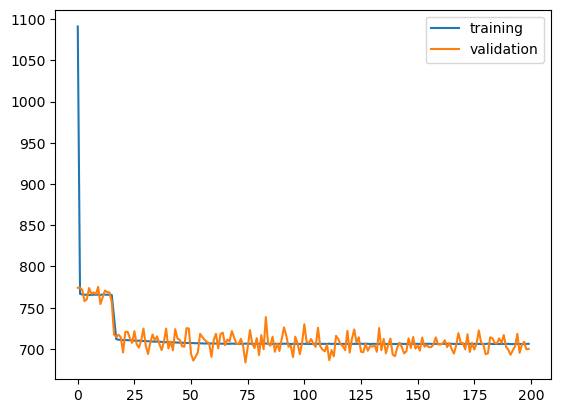

In [14]:
training_loss = np.load(folder_exp+'training_loss_final.npy')
validation_loss = np.load(folder_exp+'validation_loss_final.npy')
plt.plot(training_loss, label='training')
plt.plot(validation_loss, label='validation')
plt.legend()
plt.show()

In [15]:
def wasserstein_distance_1d(a, b):
    a_sorted, _ = torch.sort(a)
    b_sorted, _ = torch.sort(b)
    return torch.mean(torch.abs(a_sorted - b_sorted))

k = np.random.randint(N_test)
#k = 2709
print(k)
true_q_10, true_p_10 = Q010_test[k], P010_test[k]
true_q_20, true_p_20 = Q020_test[k], P020_test[k]
true_q_30, true_p_30 = Q030_test[k], P030_test[k]
true_q_40, true_p_40 = Q040_test[k], P040_test[k]
true_q_50, true_p_50 = Q050_test[k], P050_test[k]

import time
sample_q_10, sample_p_10 = model.sample(Q000_test[k], P000_test[k], L//5, dt)
sample_q_20, sample_p_20 = model.sample(Q000_test[k], P000_test[k], 2*L//5, dt)
sample_q_30, sample_p_30 = model.sample(Q000_test[k], P000_test[k], 3*L//5, dt)
sample_q_40, sample_p_40 = model.sample(Q000_test[k], P000_test[k], 4*L//5, dt)
t0 = time.time()
sample_q_50, sample_p_50 = model.sample(Q000_test[k], P000_test[k], L, dt)
t1 = time.time()
print(t1-t0)

H_00 = model.potential_energy(Q000_test[k].unsqueeze(0)) + (model.a**2*P000_test[k].unsqueeze(0)**2/2).sum()
H_10 = model.potential_energy(sample_q_10) + (model.a**2*sample_p_10**2/2).sum()
H_20 = model.potential_energy(sample_q_20) + (model.a**2*sample_p_20**2/2).sum()
H_30 = model.potential_energy(sample_q_30) + (model.a**2*sample_p_30**2/2).sum()
H_40 = model.potential_energy(sample_q_40) + (model.a**2*sample_p_40**2/2).sum()
H_50 = model.potential_energy(sample_q_50) + (model.a**2*sample_p_50**2/2).sum()
H_00 = H_10.cpu()
H_10 = H_10.cpu()
H_20 = H_20.cpu()
H_30 = H_30.cpu()
H_40 = H_40.cpu()
H_50 = H_50.cpu()
print(Q000_test[k].std())
print(P000_test[k].std())

5697
0.04075360298156738
tensor(1.1999, device='cuda:0', dtype=torch.float64)
tensor(1.4666, device='cuda:0', dtype=torch.float64)


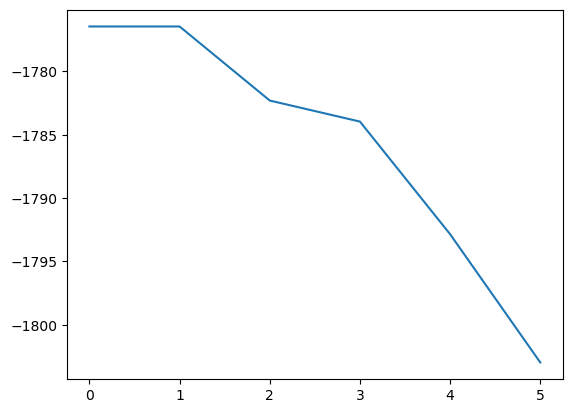

In [16]:
plt.figure()
plt.plot([H_00.detach().numpy(), H_10.detach().numpy(), H_20.detach().numpy(), H_30.detach().numpy(), H_40.detach().numpy(), H_50.detach().numpy()])
#plt.ylim([-2500,-1800])
plt.show()

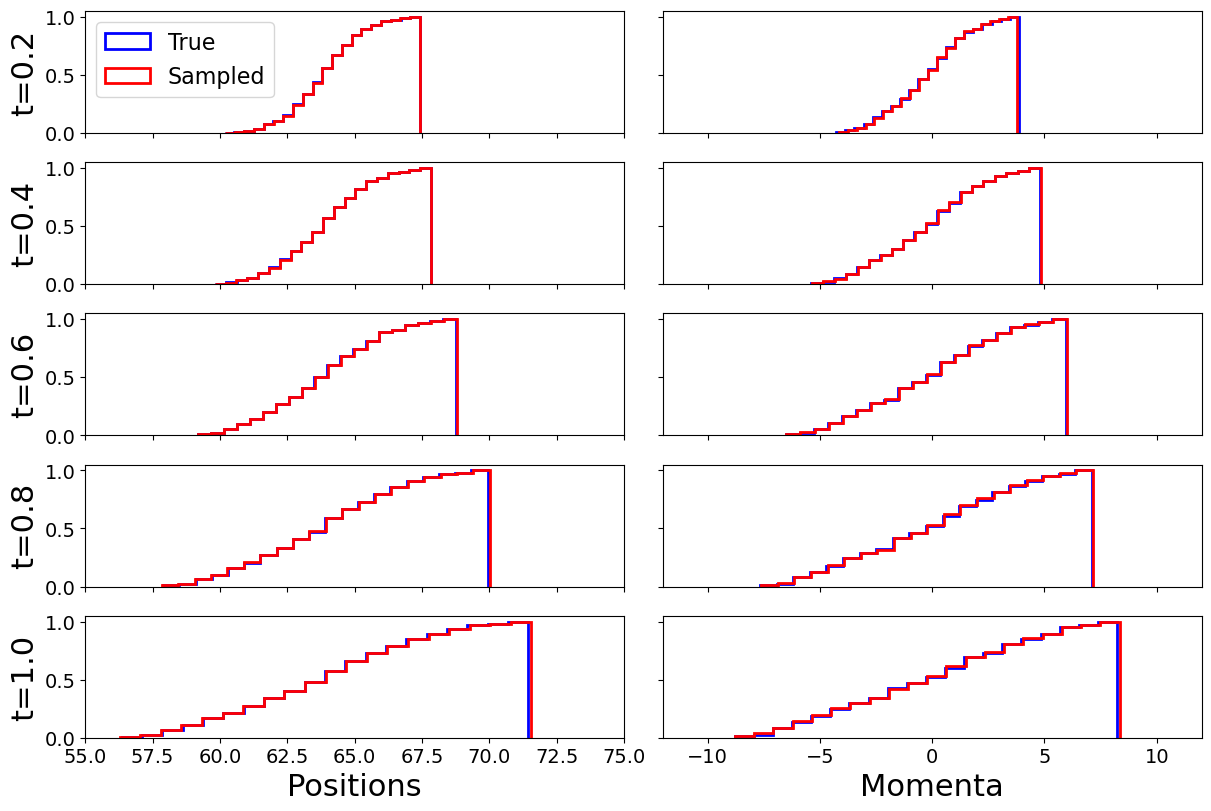

In [17]:
qmin, qmax, pmin, pmax, nbins = 55, 75, -12, 12, 20 

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, sharex='col', sharey='row', 
                                                                    gridspec_kw={'hspace': 0.1, 'wspace': 0.02},
                                                                    constrained_layout=True)
for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]:  # Loop over all axes
    ax.tick_params(axis='both', labelsize=14)  # Set font size for both x and y ticks

fig.set_figwidth(12)
fig.set_figheight(8)
# First row
ax1.hist(true_q_10.squeeze(0).detach().cpu(), 
         density=True, cumulative=True, histtype='step', bins=nbins, linewidth=2.0,
         color='blue', label='True')
ax1.hist(sample_q_10.squeeze(0).detach().cpu(), 
         density=True, cumulative=True, histtype='step', bins=nbins, linewidth=2.0,
         color='red', label='Sampled')
ax1.legend(loc='upper left', fontsize=16)
ax1.set_xlim([qmin,qmax])
ax1.set_ylabel('t=0.2', fontsize=22)
ax2.hist(true_p_10.squeeze(0).detach().cpu(), 
         density=True, cumulative=True, histtype='step', bins=nbins, linewidth=2.0,
         color='blue', label='True p-density')
ax2.hist(sample_p_10.squeeze(0).detach().cpu(), 
         density=True, cumulative=True, histtype='step', bins=nbins, linewidth=2.0,
         color='red', label='Generated p-density')
ax2.set_xlim([pmin,pmax])
#ax2.legend(loc='upper left')
# Second row
ax3.hist(true_q_20.squeeze(0).detach().cpu(), 
         density=True, cumulative=True, histtype='step', bins=nbins, linewidth=2.0,
         color='blue', label='True q-density')
ax3.hist(sample_q_20.squeeze(0).detach().cpu(), 
         density=True, cumulative=True, histtype='step', bins=nbins, linewidth=2.0,
         color='red', label='Generated q-density')
ax3.set_xlim([qmin,qmax])
ax3.set_ylabel('t=0.4', fontsize=22)
ax4.hist(true_p_20.squeeze(0).detach().cpu(), 
         density=True, cumulative=True, histtype='step', bins=nbins, linewidth=2.0,
         color='blue', label='True p-density')
ax4.hist(sample_p_20.squeeze(0).detach().cpu(), 
         density=True, cumulative=True, histtype='step', bins=nbins, linewidth=2.0,
         color='red', label='Generated p-density')
ax4.set_xlim([pmin,pmax])
# Third row
ax5.hist(true_q_30.squeeze(0).detach().cpu(), 
         density=True, cumulative=True, histtype='step', bins=nbins, linewidth=2.0,
         color='blue', label='True q-density')
ax5.hist(sample_q_30.squeeze(0).detach().cpu(), 
         density=True, cumulative=True, histtype='step', bins=nbins, linewidth=2.0,
         color='red', label='Generated q-density')
ax5.set_xlim([qmin,qmax])
ax5.set_ylabel('t=0.6', fontsize=22)
ax6.hist(true_p_30.squeeze(0).detach().cpu(), 
         density=True, cumulative=True, histtype='step', bins=nbins, linewidth=2.0,
         color='blue', label='True p-density')
ax6.hist(sample_p_30.squeeze(0).detach().cpu(), 
         density=True, cumulative=True, histtype='step', bins=nbins, linewidth=2.0,
         color='red', label='Generated p-density')
ax6.set_xlim([pmin,pmax])
# Fourth row
ax7.hist(true_q_40.squeeze(0).detach().cpu(), 
         density=True, cumulative=True, histtype='step', bins=nbins, linewidth=2.0,
         color='blue', label='True q-density')
ax7.hist(sample_q_40.squeeze(0).detach().cpu(), 
         density=True, cumulative=True, histtype='step', bins=nbins, linewidth=2.0,
         color='red', label='Generated q-density')
ax7.set_xlim([qmin,qmax])
ax7.set_ylabel('t=0.8', fontsize=22)
ax8.hist(true_p_40.squeeze(0).detach().cpu(), 
         density=True, cumulative=True, histtype='step', bins=nbins, linewidth=2.0,
         color='blue', label='True p-density')
ax8.hist(sample_p_40.squeeze(0).detach().cpu(), 
         density=True, cumulative=True, histtype='step', bins=nbins, linewidth=2.0,
         color='red', label='Generated p-density')
ax8.set_xlim([pmin,pmax])
# Fifth row
ax9.hist(true_q_50.squeeze(0).detach().cpu(), 
         density=True, cumulative=True, histtype='step', bins=nbins, linewidth=2.0,
         color='blue', label='True q-density')
ax9.hist(sample_q_50.squeeze(0).detach().cpu(), 
         density=True, cumulative=True, histtype='step', bins=nbins, linewidth=2.0,
         color='red', label='Generated q-density')
ax9.set_xlim([qmin,qmax])
ax9.set_ylabel('t=1.0', fontsize=22)
ax9.set_xlabel('Positions', fontsize=22)
ax10.hist(true_p_50.squeeze(0).detach().cpu(), 
         density=True, cumulative=True, histtype='step', bins=nbins, linewidth=2.0,
         color='blue', label='True p-density')
ax10.hist(sample_p_50.squeeze(0).detach().cpu(), 
         density=True, cumulative=True, histtype='step', bins=nbins, linewidth=2.0,
         color='red', label='Generated p-density')
ax10.set_xlim([pmin,pmax])
ax10.set_xlabel('Momenta', fontsize=22)
plt.show()

In [18]:
print("####### L = 10 #######")
print(true_q_10.mean())
print(true_q_10.std())
print(sample_q_10.mean())
print(sample_q_10.std())
print('###############')
print(true_p_10.mean())
print(true_p_10.std())
print(sample_p_10.mean())
print(sample_p_10.std())

print('\n')

print("####### L = 20 #######")
print(true_q_20.mean())
print(true_q_20.std())
print(sample_q_20.mean())
print(sample_q_20.std())
print('###############')
print(true_p_20.mean())
print(true_p_20.std())
print(sample_p_20.mean())
print(sample_p_20.std())

print('\n')

print("####### L = 30 #######")
print(true_q_30.mean())
print(true_q_30.std())
print(sample_q_30.mean())
print(sample_q_30.std())
print('###############')
print(true_p_30.mean())
print(true_p_30.std())
print(sample_p_30.mean())
print(sample_p_30.std())

print('\n')

print("####### L = 40 #######")
print(true_q_40.mean())
print(true_q_40.std())
print(sample_q_40.mean())
print(sample_q_40.std())
print('###############')
print(true_p_40.mean())
print(true_p_40.std())
print(sample_p_40.mean())
print(sample_p_40.std())

print('\n')

print("####### L = 50 #######")
print(true_q_50.mean())
print(true_q_50.std())
print(sample_q_50.mean())
print(sample_q_50.std())
print('###############')
print(true_p_50.mean())
print(true_p_50.std())
print(sample_p_50.mean())
print(sample_p_50.std())

####### L = 10 #######
tensor(63.9799, device='cuda:0', dtype=torch.float64)
tensor(1.3022, device='cuda:0', dtype=torch.float64)
tensor(63.9799, device='cuda:0', dtype=torch.float64)
tensor(1.2947, device='cuda:0', dtype=torch.float64)
###############
tensor(-0.0888, device='cuda:0', dtype=torch.float64)
tensor(1.7304, device='cuda:0', dtype=torch.float64)
tensor(-0.0888, device='cuda:0', dtype=torch.float64)
tensor(1.6908, device='cuda:0', dtype=torch.float64)


####### L = 20 #######
tensor(63.9622, device='cuda:0', dtype=torch.float64)
tensor(1.5934, device='cuda:0', dtype=torch.float64)
tensor(63.9622, device='cuda:0', dtype=torch.float64)
tensor(1.5922, device='cuda:0', dtype=torch.float64)
###############
tensor(-0.0888, device='cuda:0', dtype=torch.float64)
tensor(2.2642, device='cuda:0', dtype=torch.float64)
tensor(-0.0888, device='cuda:0', dtype=torch.float64)
tensor(2.2699, device='cuda:0', dtype=torch.float64)


####### L = 30 #######
tensor(63.9444, device='cuda:0', dtype=

In [ ]:
error05_q, error05_p = 0., 0.
error10_q, error10_p = 0., 0.
error15_q, error15_p = 0., 0.
error20_q, error20_p = 0., 0.
error25_q, error25_p = 0., 0.
for k in range(6384):
    true_q_10, true_p_10 = Q010_test[k], P010_test[k]
    true_q_20, true_p_20 = Q020_test[k], P020_test[k]
    true_q_30, true_p_30 = Q030_test[k], P030_test[k]
    true_q_40, true_p_40 = Q040_test[k], P040_test[k]
    true_q_50, true_p_50 = Q050_test[k], P050_test[k]
    sample_q_10, sample_p_10 = model.sample(Q000_test[k], P000_test[k], L//5, dt)
    sample_q_20, sample_p_20 = model.sample(Q000_test[k], P000_test[k], 2*L//5, dt)
    sample_q_30, sample_p_30 = model.sample(Q000_test[k], P000_test[k], 3*L//5, dt)
    sample_q_40, sample_p_40 = model.sample(Q000_test[k], P000_test[k], 4*L//5, dt)
    sample_q_50, sample_p_50 = model.sample(Q000_test[k], P000_test[k], L, dt)

    error05_q += float(wasserstein_distance_1d(sample_q_10, Q010_test[k]))
    error05_p += float(wasserstein_distance_1d(sample_p_10, P010_test[k]))

    error10_q += float(wasserstein_distance_1d(sample_q_20, Q020_test[k]))
    error10_p += float(wasserstein_distance_1d(sample_p_20, P020_test[k]))

    error15_q += float(wasserstein_distance_1d(sample_q_30, Q030_test[k]))
    error15_p += float(wasserstein_distance_1d(sample_p_30, P030_test[k]))

    error20_q += float(wasserstein_distance_1d(sample_q_40, Q040_test[k]))
    error20_p += float(wasserstein_distance_1d(sample_p_40, P040_test[k]))

    error25_q += float(wasserstein_distance_1d(sample_q_50, Q050_test[k]))
    error25_p += float(wasserstein_distance_1d(sample_p_50, P050_test[k]))
    
    if (k+1)%500 == 0: print(k)

In [ ]:
print(error05_q/6384)
print(error05_p/6384)

print(error10_q/6384)
print(error10_p/6384)

print(error15_q/6384)
print(error15_p/6384)

print(error20_q/6384)
print(error20_p/6384)

print(error25_q/6384)
print(error25_p/6384)